# Sitcom Analysis
How have iconic sitcoms evolved between the mid-2000s and early 2010s?  Which shows performed better than others?

## Goal
The goal of this project is to investigate trends in popular sitcoms released between the mid-2000s and early 2010s.  This project will take a look at IMDB ratings, release dates, and any other data that may offer insights into what factors may contribute to a sitcom's success.  By comparing the performance of these sitcoms against each other, we can gain valuable insights on what factors future sitcoms should emulate to achieve similar success and which episodes/seasons producers may consider revisiting in potential revivals of these sitcoms.
### List of Shows Included in this Analysis:
* **It's Always Sunny in Philadelphia** (2005 - Present)
* **The Office** (2005 - 2013)
* **30 Rock** (2006 - 2013)
* **The Big Bang Theory** (2007 - 2019)
* **Community** (2009 - 2015)
* **Modern Family** (2009 - 2020)
* **Parks and Recreation** (2009 -2015)
* **Brooklyn 99** (2013 - 2021)

## Setup
* First, extract the desired data from each show's episode dataset.
* We'll need the following:
    - Season Number
    - Episode Number (per season)
    - Episode Number (overall)
    - Episode Title
    - IMDB Rating
    - Airdate
      - Year
      - Month
      - Weekday
    - Show Name
* Then, combine the show datasets together, both in DataFrame and List form.


In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime as dt
pd.options.mode.chained_assignment = None
import matplotlib.ticker as ticker


In [165]:
# Convert columns to lower case and rename as necessary
def standardize_columns(df, column_map):
    df = df.copy()
    df = df.rename(columns=column_map)
    df.columns = df.columns.str.lower()
    return df

# Add overall episode number column
def add_overall_episode_number(df):
    df = df.copy()
    df["episode_num_overall"] = range(1, len(df) + 1)
    return df

# Add season episode number column
def add_season_episode_numbers(df):
    df = df.copy()
    episode_num = []
    current_season = None
    ep_num = 1

    for season in df["season"]:
        if season != current_season:
            ep_num = 1
            current_season = season
        episode_num.append(ep_num)
        ep_num += 1

    df["episode_num"] = episode_num
    return df

# Parse the airdate and create the year, month, and weekday columns
def parse_airdate(df, airdate_col="airdate"):
    df = df.copy()
    df[airdate_col] = pd.to_datetime(df[airdate_col], errors="coerce", format="mixed")
    df["year"]=df[airdate_col].apply(lambda x:x.strftime("%Y"))
    df["month"]=df[airdate_col].apply(lambda x:x.strftime("%b"))
    df["weekday"]=df[airdate_col].apply(lambda x:x.strftime("%a"))
    return df


In [166]:
def process_sitcom_df(df, column_map, show_name, has_season_ep=False):
    """
    Cleans and standardizes a sitcom dataframe.
    
    Parameters:
    - df: Raw dataframe
    - column_map: Dictionary to rename columns
    - show_name: String, e.g., "The Office"
    - has_season_ep: If the dataframe already has correct season/episode numbers
    """
    df = standardize_columns(df, column_map)
    df = add_overall_episode_number(df)
    
    if not has_season_ep:
        df = add_season_episode_numbers(df)
    
    df = parse_airdate(df, "airdate")
    df["show"] = show_name
    
    return df[["season", "episode_num", "episode_num_overall", "title", "airdate", "rating", "show","year","month","weekday"]]


In [167]:
# It's Always Sunny in Philadelphia
iasip_data = pd.read_csv("iasip.csv",parse_dates=['airdate'])

iasip = iasip_data[1:]
iasip["season"] = iasip["seasons"].apply(lambda x: int(x.replace("S","")))
iasip["title"]= iasip["title"].apply(lambda x: x.replace("&","and"))
iasip["episode_num"] = iasip["episode"].apply(lambda x: int(x.replace("Ep","")))
iasip = process_sitcom_df(iasip,{},"IASIP",has_season_ep=True)

# Season 16 is missing from the iasip df, so let's add it here:
new_eps = [
    (16, 1, 163, "The Gang Inflates", "2023-06-07",8.1),
    (16, 2, 164, "Frank Shoots Every Member of the Gang", "2023-06-07",7.7),
    (16, 3, 165, "The Gang Gets Cursed", "2023-06-14",7.5),
    (16, 4, 166, "Frank vs. Russia", "2023-06-21",8.7),
    (16, 5, 167, "Celebrity Booze: The Ultimate Cash Grab", "2023-06-28",8.0),
    (16, 6, 168, "Risk E. Rat’s Pizza and Amusement Center", "2023-07-05",7.8),
    (16, 7, 169, "The Gang Goes Bowling", "2023-07-12",8.7),
    (16, 8, 170, "Dennis Takes a Mental Health Day", "2023-07-19",9.2),
]
season_16 = process_sitcom_df(pd.DataFrame(new_eps, columns=[
    "season","episode_num","episode_num_overall","title","airdate","rating"
]),{},"IASIP",has_season_ep=True)

iasip=pd.concat([iasip,season_16])

# The Office
the_office_data = pd.read_csv("the_office.csv",index_col=[0]).reset_index(drop=False)
office_map = {
    "Season": "season", "index": "episode_num_overall",
    "Ratings": "rating", "EpisodeTitle": "title", "Date": "airdate"
}
the_office = process_sitcom_df(the_office_data, office_map, "The Office", has_season_ep=False)

# Community
community_data = pd.read_csv("community.csv",index_col=[0]).reset_index(drop=False)
community_map = {"episode_number": "episode_num"}
community = process_sitcom_df(community_data, community_map, "Community", has_season_ep=True)

# 30 Rock
thirty_rock_data = pd.read_csv("30_rock.csv",index_col=[0]).reset_index(drop=False)
rock_map = {"original_air_date": "airdate", "imdb_rating": "rating"}
thirty_rock = process_sitcom_df(thirty_rock_data, rock_map, "30 Rock", has_season_ep=True)

# Parks and Rec
parks_and_rec_data = pd.read_csv("parks_and_rec.csv")
parks_map = {}  # Column names already lowercase and aligned
parks_and_rec = process_sitcom_df(parks_and_rec_data, parks_map, "Parks and Rec", has_season_ep=False)

# Brooklyn 99
brooklyn_99_data = pd.read_csv("brooklyn_99.csv")
b99_map = {"original_air_date": "airdate", "imdb_rating": "rating"}
brooklyn_99 = process_sitcom_df(brooklyn_99_data, b99_map, "Brooklyn 99", has_season_ep=True)

# Big Bang Theory
big_bang_theory_data = pd.read_csv("big_bang_theory.csv")
bbt_map = {"original_air_date": "airdate", "imdb_rating": "rating"}
big_bang_theory = process_sitcom_df(big_bang_theory_data, bbt_map, "Big Bang Theory", has_season_ep=True)[1:]

# Modern Family
modern_family_data = pd.read_csv("modern_family.csv")
modern_family_data[["season","episode_num"]] = modern_family_data["Season-Episode"].replace("E","").str.split("-",expand=True)
modern_family_data["season"]=modern_family_data["season"].apply(lambda x: int(x.replace("S","")))
modern_family=process_sitcom_df(modern_family_data,{},"Modern Family",has_season_ep=False)

# Combine all shows into a single DF for our purposes, and also make a list
all_shows= pd.concat([iasip,the_office,community,thirty_rock,big_bang_theory,parks_and_rec,modern_family,brooklyn_99], ignore_index=True)
sitcoms = [the_office,iasip,thirty_rock,big_bang_theory,community,parks_and_rec,modern_family,brooklyn_99]

## Initial Exploration
* Preview the first few rows of the DataFrame to verify the dataset contains the necessary columns.
* Check the data types of each column.

In [168]:
print(all_shows.head(5))

   season  episode_num  episode_num_overall  \
0       1            1                    1   
1       1            2                    2   
2       1            3                    3   
3       1            4                    4   
4       1            5                    5   

                                   title    airdate  rating   show  year  \
0                   The Gang Gets Racist 2005-08-04     8.2  IASIP  2005   
1              Charlie Wants an Abortion 2005-08-11     8.2  IASIP  2005   
2  Underage Drinking: A National Concern 2005-08-16     8.3  IASIP  2005   
3                     Charlie Has Cancer 2005-08-23     8.1  IASIP  2005   
4                              Gun Fever 2005-08-30     7.9  IASIP  2005   

  month weekday  
0   Aug     Thu  
1   Aug     Thu  
2   Aug     Tue  
3   Aug     Tue  
4   Aug     Tue  


In [169]:
print(all_shows.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   season               1411 non-null   int64         
 1   episode_num          1411 non-null   int64         
 2   episode_num_overall  1411 non-null   int64         
 3   title                1411 non-null   object        
 4   airdate              1411 non-null   datetime64[ns]
 5   rating               1411 non-null   float64       
 6   show                 1411 non-null   object        
 7   year                 1411 non-null   object        
 8   month                1411 non-null   object        
 9   weekday              1411 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 110.4+ KB
None


### Which show released the most episodes?
* To explore this, we will use a bar graph to compare the episode counts of each sitcom.

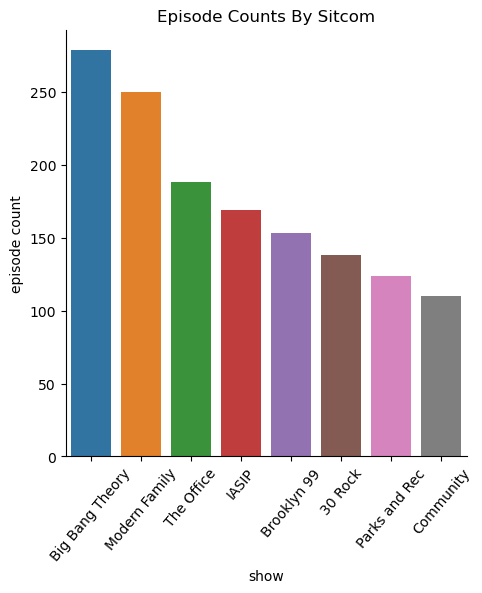

              show  count
0  Big Bang Theory    279
1    Modern Family    250
2       The Office    188
3            IASIP    169
4      Brooklyn 99    153
5          30 Rock    138
6    Parks and Rec    124
7        Community    110


In [170]:
episode_counts = all_shows["show"].value_counts().reset_index()
sns.catplot(data=episode_counts,x="show",y="count",hue="show",kind="bar")
plt.xticks(rotation=50)
plt.ylabel("episode count")
plt.title("Episode Counts By Sitcom")
plt.show()
print(episode_counts)

* At 279 episodes, ***The Big Bang Theory*** has the highest episode count.
* At 110 episodes, ***Community*** has the fewest episodes.
### Which show has the most seasons?
* We will compare the season counts of each show using a bar graph.

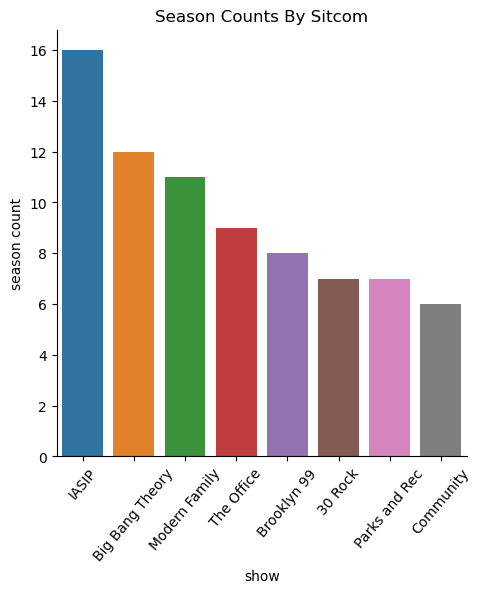

              show  num_seasons
4            IASIP           16
1  Big Bang Theory           12
5    Modern Family           11
7       The Office            9
2      Brooklyn 99            8
0          30 Rock            7
6    Parks and Rec            7
3        Community            6


In [171]:
season_counts = all_shows.groupby("show")["season"].max().reset_index().sort_values("season",ascending=False).rename(columns={"season":"num_seasons"})
sns.catplot(data=season_counts,x="show",y="num_seasons",hue="show",kind="bar")
plt.xticks(rotation=50)
plt.ylabel("season count")
plt.title("Season Counts By Sitcom")
plt.show()
print(season_counts)

* ***It's Always Sunny in Philadelphia*** has the most seasons with 16.
  - As the only currently airing sitcom, excluding it reveals that ***The Big Bang Theory*** has the most seasons with 12.
* ***Community*** has the least seasons with 6.
### Which show has the most episodes per season?
* We will investigate this by calculating the average number of episodes per season for each sitcom, and then compare with a bar graph.

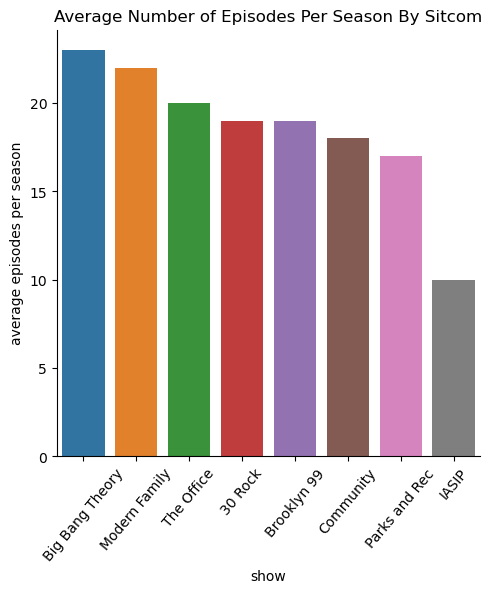

              show  avg_eps_per_season
1  Big Bang Theory                23.0
5    Modern Family                22.0
7       The Office                20.0
0          30 Rock                19.0
2      Brooklyn 99                19.0
3        Community                18.0
6    Parks and Rec                17.0
4            IASIP                10.0


In [172]:
ep_per_season=pd.DataFrame(all_shows.value_counts(["show","season"]).reset_index().groupby("show")["count"].mean().reset_index())
ep_per_season=ep_per_season.rename(columns={'count':'avg_eps_per_season'}).sort_values('avg_eps_per_season',ascending=False)
ep_per_season['avg_eps_per_season']=np.floor(ep_per_season['avg_eps_per_season'])
sns.catplot(data=ep_per_season,x="show",y='avg_eps_per_season',hue="show",kind="bar")
plt.xticks(rotation=50)
plt.ylabel("average episodes per season")
plt.title("Average Number of Episodes Per Season By Sitcom")
plt.show()
print(ep_per_season)

* ***The Big Bang Theory*** has the most episodes per season averaging at about 23.
* ***It's Always Sunny in Philadelphia*** has the least episodes per season with an average of about 10.

## Rating Trends
* IMDB ratings are a good way to gauge the response from critics and audiences towards movies and television.  Using these ratings, we can investigate what factors may lead to higher ratings in sitcoms.
### At a high level, how did each show perform in ratings?
* We will calculate the average rating across all episodes for each sitcom and compare in a bar graph.

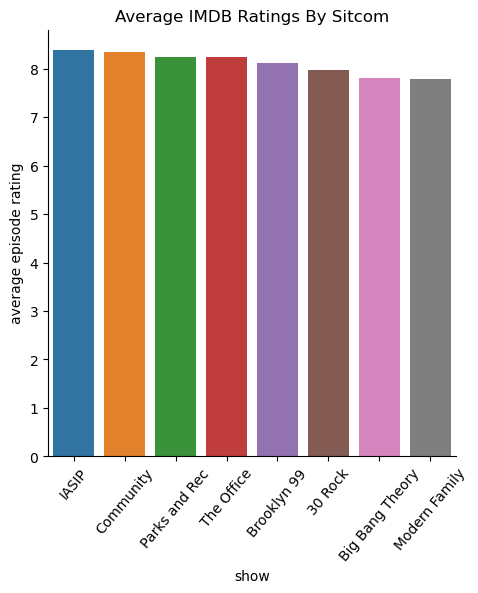

              show  episode_avg
4            IASIP     8.386982
3        Community     8.338182
6    Parks and Rec     8.241129
7       The Office     8.237234
2      Brooklyn 99     8.127451
0          30 Rock     7.978261
1  Big Bang Theory     7.817204
5    Modern Family     7.780000


In [173]:
# mean of episode ratings per show
episode_avgs = all_shows.groupby("show")["rating"].mean().reset_index(name="episode_avg").sort_values("episode_avg",ascending=False)
sns.catplot(kind="bar",hue="show",x="show",y="episode_avg",data=episode_avgs)
plt.xticks(rotation=50)
plt.ylabel("average episode rating")
plt.title("Average IMDB Ratings By Sitcom")
plt.show()
print(episode_avgs)

* On average, ***It's Always Sunny In Philadelphia*** is rated the highest, while ***Modern Family*** is rated the lowest.
* We will use a boxplot to compare and contrast the statistics that contributed to these averages.

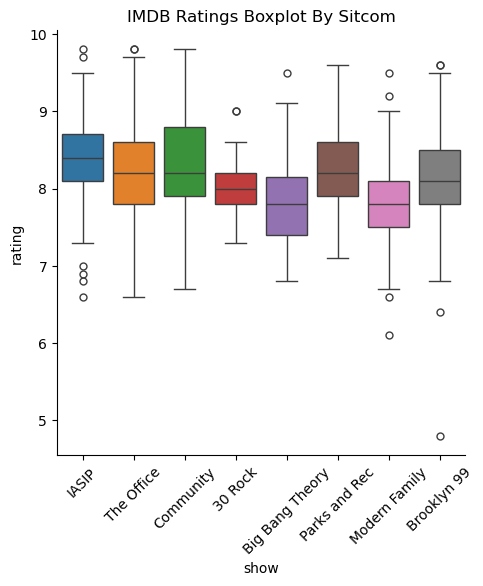

In [174]:
sns.catplot(x="show",y="rating",data=all_shows,kind="box",hue="show")
plt.xticks(rotation=45)
plt.title("IMDB Ratings Boxplot By Sitcom")
plt.show()

* From the boxplot, we can see that the highest ratest episodes are round the 9-10 range, and the lowest rated episodes are in the 6-7.
* ***The Office***, ***Modern Family***, and ***Brooklyn 99*** all possess outlier episodes that stand out in either direction.
* ***30 Rock*** shows the shortest whiskers indicating more consistent ratings, while shows like ***Community***, ***The Office***, and ***Brooklyn 99*** seem more inconsistent.  We can graph the standard deviation of episode ratings to confirm this.
### Which show has the most consistent ratings between episodes?
* We will calculate the IMDB rating standard deviation for each show and compare in a bar graph.

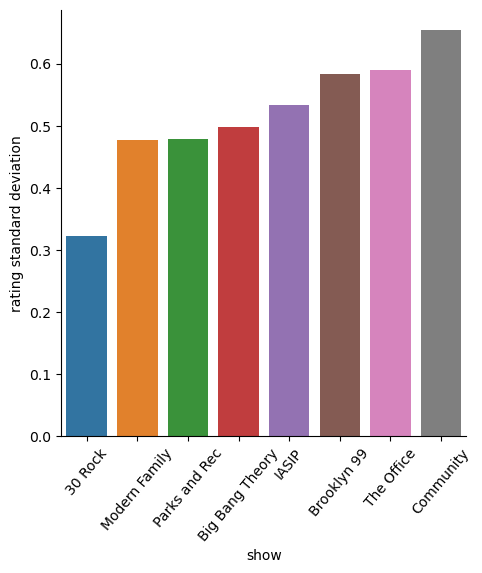

              show  episode_std
0          30 Rock     0.321661
5    Modern Family     0.477779
6    Parks and Rec     0.479161
1  Big Bang Theory     0.497394
4            IASIP     0.532801
2      Brooklyn 99     0.583798
7       The Office     0.589930
3        Community     0.654130


In [175]:
# Std of episode ratings per show
episode_std = all_shows.groupby("show")["rating"].std().reset_index(name="episode_std").sort_values("episode_std")
sns.catplot(kind="bar",hue="show",x="show",y="episode_std",data=episode_std)
plt.xticks(rotation=50)
plt.ylabel("rating standard deviation")
plt.show()
print(episode_std)

* *30 Rock* is the most consistent in ratings between episodes.
* *Community* is the least consistent with episode ratings.

### Quality vs. Quantity: Do More Episodes Lead To Higher Ratings?  What About Consistency?
* To investigate the connection between IMDB ratings and episode quantity, we will calculate the correlation coefficients.
  - First, we will find the correlation between average IMDB rating and episode count.
  - Then, we will find the correlation between IMDB rating standard deviation and episode count.

In [176]:
#join the average ratings and episode count dataframes to find correlation coefficients
avg_vs_count=pd.merge(episode_avgs,episode_counts,on="show")
print(avg_vs_count.select_dtypes(include=np.number).corr())

             episode_avg     count
episode_avg     1.000000 -0.742481
count          -0.742481  1.000000


In [177]:
#join the standard deviation ratings and episode count dataframes to find correlation coefficients
std_vs_count=pd.merge(episode_std,episode_counts,on="show")
print(std_vs_count.select_dtypes(include=np.number).corr())

             episode_std     count
episode_std     1.000000 -0.126882
count          -0.126882  1.000000


* There looks to be a strong negative correlation between the number of episodes and average ratings.
* Longer-running shows may tend to have lower ratings on average.
* However, episode count has a weak negative correlation with the standard deviation, meaning we cannot conclude a connection between ratings consistency and episode count.
### How did each show perform season by season?
* For each show, we shall calculate the average rating for each of its seasons and plot it out to compare the average season ratings between shows.

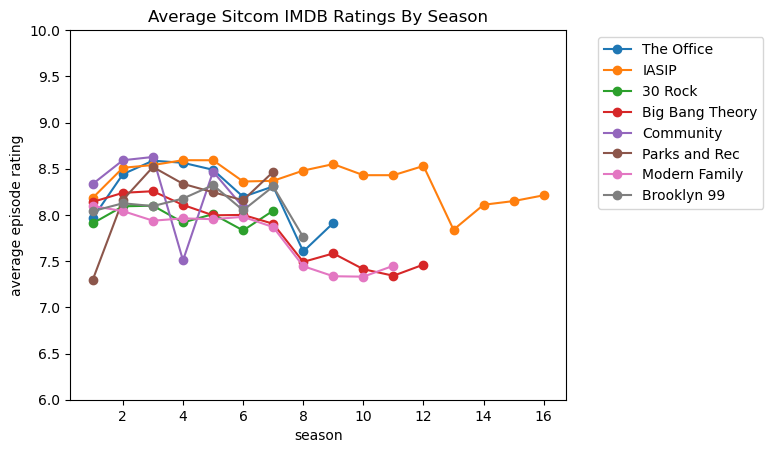

In [178]:
season_ratings=[]
for show in sitcoms:
    name = show["show"].iloc[0]
    # group each show dataframe by season to find the average IMDB rating for that season
    rating_by_season = show.groupby(["show","season"])["rating"].mean().reset_index()
    season_ratings.append(rating_by_season)
    plt.plot(rating_by_season["season"], rating_by_season["rating"], marker='o', label=name)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.ylim(6,10)
    plt.title("Average Sitcom IMDB Ratings By Season")
    plt.xlabel("season")
    plt.ylabel("average episode rating")

At a glance, we can see:
* Every sitcom except for ***Modern Family*** had a higher average rating in its second season.
* Several sitcom ratings peaked around the second or third season
* The following sitcoms end with noticeably lower ratings than when they started:
  - ***The Big Bang Theory***
  - ***Modern Family***
  - ***Brooklyn 99***
* A noticeable drop in ratings from the Season 7 to 8 occurs for:
  - ***The Big Bang Theory***
  - ***Modern Family***
  - ***Brooklyn 99***
  - ***The Office***
* ***Parks and Recreation***'s final season has notably higher ratings than its first.
* ***30 Rock***'s ratings across seasons look the most consistent, lining up with its episode-to-episode standard deviation.
* ***Community***'s ratings peaked in Season 2 and dropped significantly in Season 4. However, ratings recovered in Season 5...
* Let's investigate further and see what the best and worst season was for each show.

### What was the best and worst season for each sitcom?
* To investigate this, we will look at the season averages we calculated for each show.  We will find the seasons with the minimum and maximum average rating for each show.
* We will then visualize and compare our findings in a histogram.

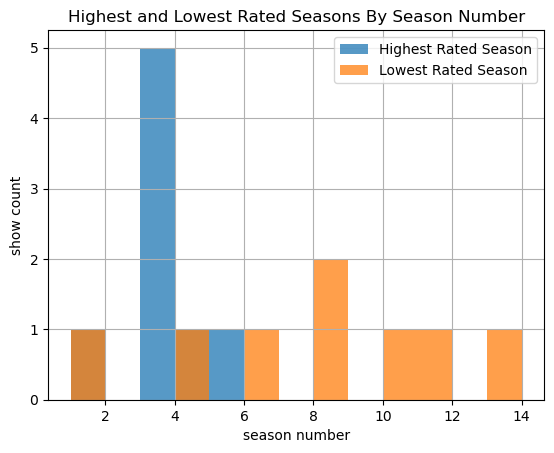

              show  top_season  top_rating  bottom_season  bottom_rating
0       The Office           3        8.59              8           7.60
1            IASIP           4        8.59             13           7.84
2          30 Rock           3        8.10              6           7.83
3  Big Bang Theory           3        8.26             11           7.34
4        Community           3        8.63              4           7.51
5    Parks and Rec           3        8.52              1           7.30
6    Modern Family           1        8.10             10           7.33
7      Brooklyn 99           5        8.32              8           7.76


In [179]:
show_seasons={"show":[],"top_season":[],"top_rating":[],"bottom_season":[],"bottom_rating":[]}
for show in season_ratings:
    # For each show, find the seasons with the highest and lowest average IMDB rating.
    # Add each result to the show_seasons dictionary.
    rating_sorted = show.groupby(["show","season"])["rating"].mean().reset_index().sort_values("rating")
    show_seasons["show"].append(rating_sorted["show"].iloc[0])
    show_seasons["top_season"].append(rating_sorted["season"].iloc[-1])
    show_seasons["bottom_season"].append(rating_sorted["season"].iloc[0])
    show_seasons["top_rating"].append(round(rating_sorted["rating"].iloc[-1],2))
    show_seasons["bottom_rating"].append(round(rating_sorted["rating"].iloc[0],2))
# Convert show_seasons into a dataframe and plot as a histogram
show_seasons =pd.DataFrame(show_seasons).head(len(show_seasons["show"]))
show_seasons["top_season"].hist(bins=np.arange(min(show_seasons["top_season"]), max(show_seasons["top_season"]) + 2) ,alpha=0.75,label="Highest Rated Season")
#plt.show()
show_seasons["bottom_season"].hist(bins=np.arange(min(show_seasons["bottom_season"]), max(show_seasons["bottom_season"]) + 2) ,alpha=0.75,label = "Lowest Rated Season")
plt.legend()
plt.xlabel("season number")
plt.ylabel("show count")
plt.title("Highest and Lowest Rated Seasons By Season Number")
plt.show()
print(show_seasons)

* 5 out of 8 shows peaked in ratings at Season 3
* Meanwhile, we see more variety when looking at the number of each show's worst season.
### Is There A Correlation Between Season Number and Episode Ratings?
* We will check for correlation between season and episode ratings by finding the correlation coefficient between the season number and the IMDB rating.

In [180]:
all_shows[["season","rating"]].corr()

,season,rating
season,1.00000,-0.28569
rating,-0.28569,1.00000


* Despite Season 3 being the most frequent top rated season in our data, a correlation value of -0.28569 means that we cannot form a reasonable conclusion that season number and ratings are linked.
* This suggests that season number alone is not a factor in how a show may perform.

## Airdate Trends
* Let's try finding patterns in the airdates of these sitcoms, and see if there are trends that future sitcoms may want to emulate.
### How Does The Time Between Seasons Change For Each Show?
* For each show, we will first calculate the airdate of the first and last episode of each season.
* We will then calculate the difference in days between the end of each season and the start of the next.  This is the interval between seasons.
* Finally, we will plot the lengths of these intervals and compare between shows.

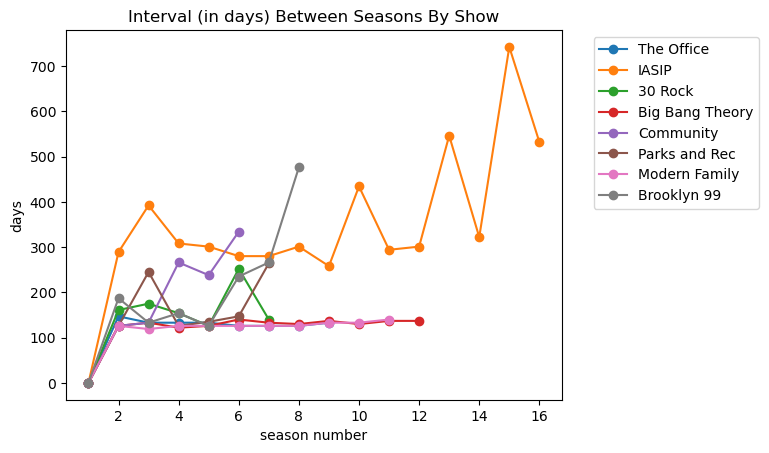

In [181]:
show_intervals=[]
for show in sitcoms:
    name = show["show"].iloc[0]
    dates=show.groupby("season").agg({"airdate":["min","max"]}).reset_index()
    dates["show"]=name
    gaps=[0]
    for i in range(1,len(dates)):
        gap=(dates["airdate","min"][i]-dates["airdate","max"][i-1]).days
        gaps.append(gap)
    show_gaps= pd.DataFrame({"interval":gaps})
    show_gaps["show"]=name
    show_intervals.append(show_gaps)
    plt.xlabel("season number")
    plt.ylabel("days")
    plt.title("Interval (in days) Between Seasons By Show")
    plt.plot(dates["season"], gaps,  marker='o',label=name)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

* Shows like ***The Office***, ***Modern Family***, and ***The Big Bang Theory*** premiered each season in what looks to be very consistent intervals.
* ***It's Always Sunny In Philadelphia*** appears to have taken the longest gap between its first and second season.  Its gaps between seasons appear to get more inconsistent as time goes on.
* To verify the consistency of these gaps, let's find out the average interval and the standard deviation and compare with a bar graph.

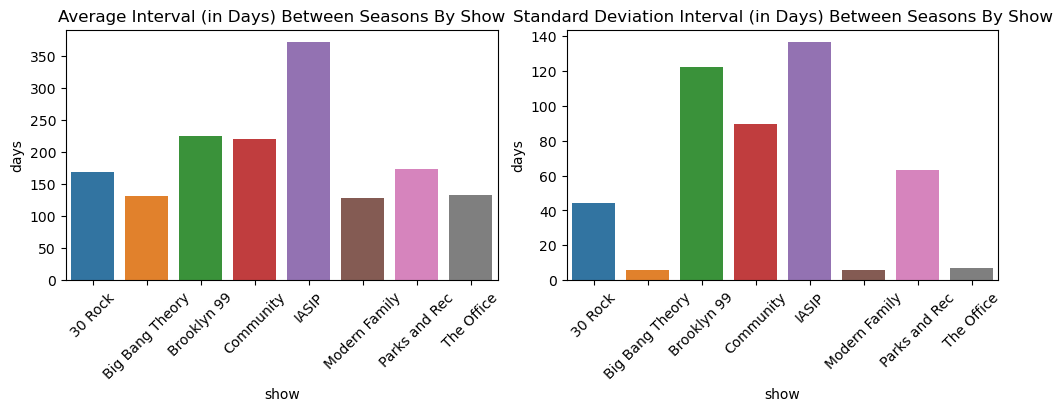

In [182]:
# First, create a dataframe from the season intervals we calculated previously.
intervals_df=pd.concat(show_intervals).reset_index().rename(columns={"index":"season"})
intervals_df["season"]=intervals_df["season"]+1
intervals_df=intervals_df[intervals_df["season"]!=1]

#Next, calculate the average number of days between seasons for each show.
intervals_avg=intervals_df.groupby("show")["interval"].mean().reset_index()

#Then, calculate the standard deviation for the intervals between seasons for each show.
intervals_std=intervals_df.groupby("show")["interval"].std().reset_index()

#Then, use bar graphs to compare the average and standard deviations for the season intervals for each show.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x="show",y="interval",data=intervals_avg,hue="show",ax=axes[0])
axes[0].set_title("Average Interval (in Days) Between Seasons By Show")
plt.xticks(rotation=45)
axes[0].tick_params(axis='x', rotation=45)
sns.barplot(x="show",y="interval",data=intervals_std,hue="show",ax=axes[1])
axes[0].set_ylabel("days")
axes[1].set_title("Standard Deviation Interval (in Days) Between Seasons By Show")
axes[1].set_ylabel("days")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
fig.set_constrained_layout(True)
plt.show()

### Do Longer Gaps Between Seasons Improve Ratings?
* To find this out, we will find the correlation coefficient between the average ratings for each show's season and the number of days preceding that season.
* Then, we will examine the correlation coefficients between average interval length, the standard deviation of the interval length, and the average episode rating for each show.

In [183]:
season_avgs=all_shows.groupby(["show","season"])["rating"].mean().reset_index()
season_avgs = season_avgs[season_avgs["season"]>1]
avg_vs_interval=pd.merge(intervals_df,season_avgs,on=("show","season"),suffixes=('_intv','_avg'))
avg_vs_interval[["interval","rating"]].corr()

,interval,rating
interval,1.000000,0.218946
rating,0.218946,1.000000


In [184]:
ratings_vs_intervals=pd.merge(pd.merge(intervals_avg,intervals_std,on="show",suffixes=('_avg','_std')),episode_avgs,on="show")
ratings_vs_intervals.select_dtypes(include=np.number).corr()

,interval_avg,interval_std,episode_avg
interval_avg,1.000000,0.893089,0.671237
interval_std,0.893089,1.000000,0.684160
episode_avg,0.671237,0.684160,1.000000


* The correlation coefficient between season interval (in days) and season average rating is 0.218946, which is too weak for us to form a reasonable conclusion.
* Likewise, with correlation coefficients of 0.671237 and 0.684160, we cannot reasonable conclude that the average number of days between seasons or standard deviation of those time gaps respectively has any correlation with a show's average episode ratings.
* However, with a correlation coefficient of 0.893089, we find a strong positive correlation between the average gap between seasons and the standard deviation of those gaps.  This hints that sitcoms with smaller gaps between seasons are able to stick to more consistent release schedules.
* We should remember that a hiatus between seasons could occur for any number of reasons.

### What Is The Most Popular Month For Airing New Episodes?
* To investigate this, we will calculate the number of episodes released in each month and plot the findings in a bar graph.
* We will also visually indicate which shows aired episodes on that specific month.

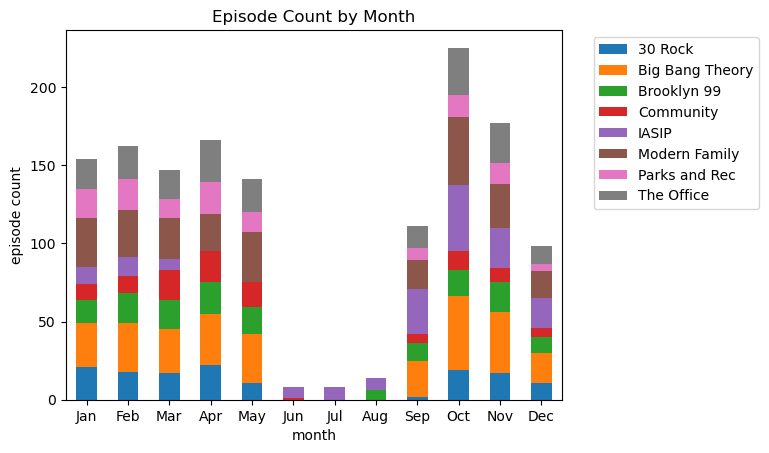

   month  count
0    Oct    225
1    Nov    177
2    Apr    166
3    Feb    162
4    Jan    154
5    Mar    147
6    May    141
7    Sep    111
8    Dec     98
9    Aug     14
10   Jun      8
11   Jul      8


In [185]:
# Create a list of month names to keep the x axis labels in chronological order.
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_plot=all_shows.groupby(["show","month"]).size().reset_index(name="count").pivot(columns='show',index='month',values='count').reindex(months)
month_plot.plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title("Episode Count by Month")
plt.ylabel("episode count")
plt.show()
print(all_shows["month"].value_counts().reset_index())

* The graph shows that October is the most common month for new sitcom episodes to air.
* Very few sitcoms air new episodes in the summer (June - August), with ***It's Always Sunny In Philadelphia*** being the only one to broadcast over the whole summer range.

### What Is The Most Popular Day For Airing New Episodes?
* We will investigate this by calculating the number of episodes aired on each day of the week and then compare the quantities in a bar graph.
* We will also visually indicate which shows aired episodes on that specific week day.

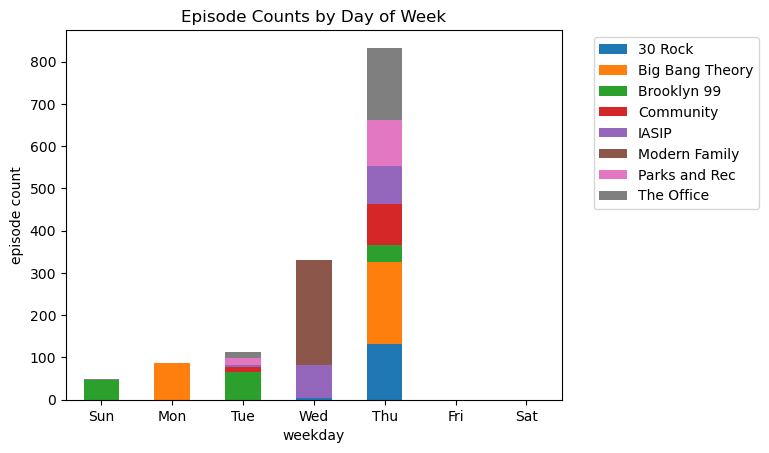

  weekday  count
0     Thu    833
1     Wed    331
2     Tue    113
3     Mon     86
4     Sun     48


In [186]:
# Create list of week day names to keep x axis labels in consistent order.
day_names = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
day_plot=all_shows.groupby(["show","weekday"]).size().reset_index(name="count").pivot(columns='show',index='weekday',values='count').reindex(day_names)
day_plot.plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.ylabel("episode count")
plt.title("Episode Counts by Day of Week")
plt.show()
print(all_shows["weekday"].value_counts().reset_index())

* From this graph, it can be observed that Thursday is the most popular day of the week to air new episodes.
* 833 episodes premiered on a Thursday across every show except ***Modern Family***, which premiered exclusively on Wednesdays.
* Outside of ***Modern Family***, each sitcom aired episodes on 2-3 different week days.
### How Did Each Sitcom's Ratings Change Over The Years?
* To find this out, we will calculate the cumulative mean of each sitcom by year and then compare our findings in a line plot.

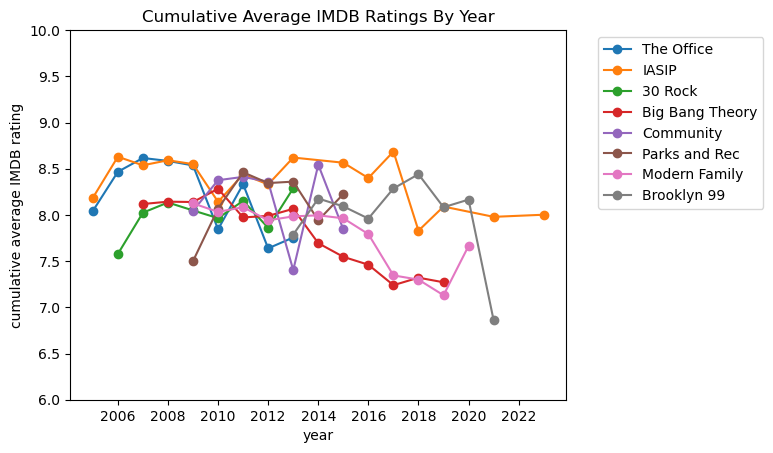

In [187]:
for show in sitcoms:
    name = show["show"].iloc[0]
    rating_by_year = show.groupby("year")["rating"].expanding().mean().reset_index().groupby("year")["rating"].mean().reset_index()
    plt.plot(pd.to_datetime(rating_by_year['year'], format='%Y'), rating_by_year["rating"], marker='o', label=name)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.ylim(6,10)
    plt.xlabel("year")
    plt.ylabel("cumulative average IMDB rating")
    plt.title("Cumulative Average IMDB Ratings By Year")
plt.show()   

* What is shown in this plot reaffirms some points from the Season-by-Season graph:
  - ***Community***'s average rating dips in 2013, coinciding with the low performance of its 4th season.
  - ***Brooklyn 99***'s drop in 2021 lines up with the low ratings of its final season.
  - ***Parks and Recreation*** shows a dramatic rise in from 2009 to 2011 aligning with its peak ratings in the 2nd and 3rd seaons.
* There are multiple years where multiple shows are airing at the same time.  One good way to compare the performance of these shows would be simulate a period in which they were in direct competition in one-another, so let's find a year in which all 8 shows aired simultaneously.

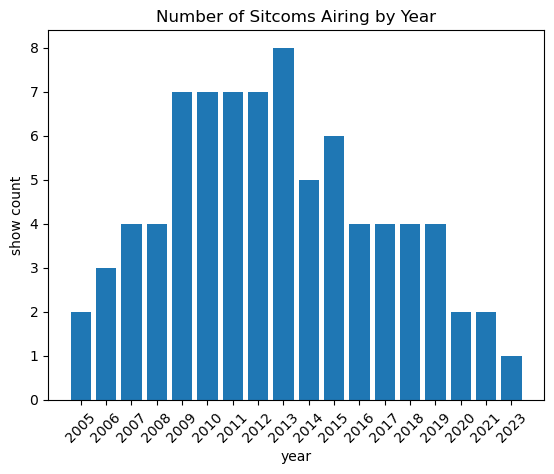

In [188]:
year_counts = pd.DataFrame(all_shows.groupby("year")["show"].nunique().reset_index()).rename(columns={"show":"show_count"})
plt.bar(year_counts["year"],year_counts["show_count"])
plt.xticks(rotation=45)
plt.ylabel("show count")
plt.xlabel("year")
plt.title("Number of Sitcoms Airing by Year")
plt.show()

* ***2013*** is the only year in which all shows in the dataset were airing.  With this, we can dive deeper into analyzing the performance of the shows during this period.

## 2013 Performance Analysis
* All 8 of the shows in the dataset aired in 2013, so filtering out this time period will give us a better insight as to how they performed next to each other.
### In 2013, How Did Each Show Perform In Ratings?
* We will visualize this by first comparing the boxplot of each show's 2013 IMDB ratings to their overall IMDB ratings.
* Then, we will compare the bar graphs of each show's average 2013 ratings to their overall ratings.

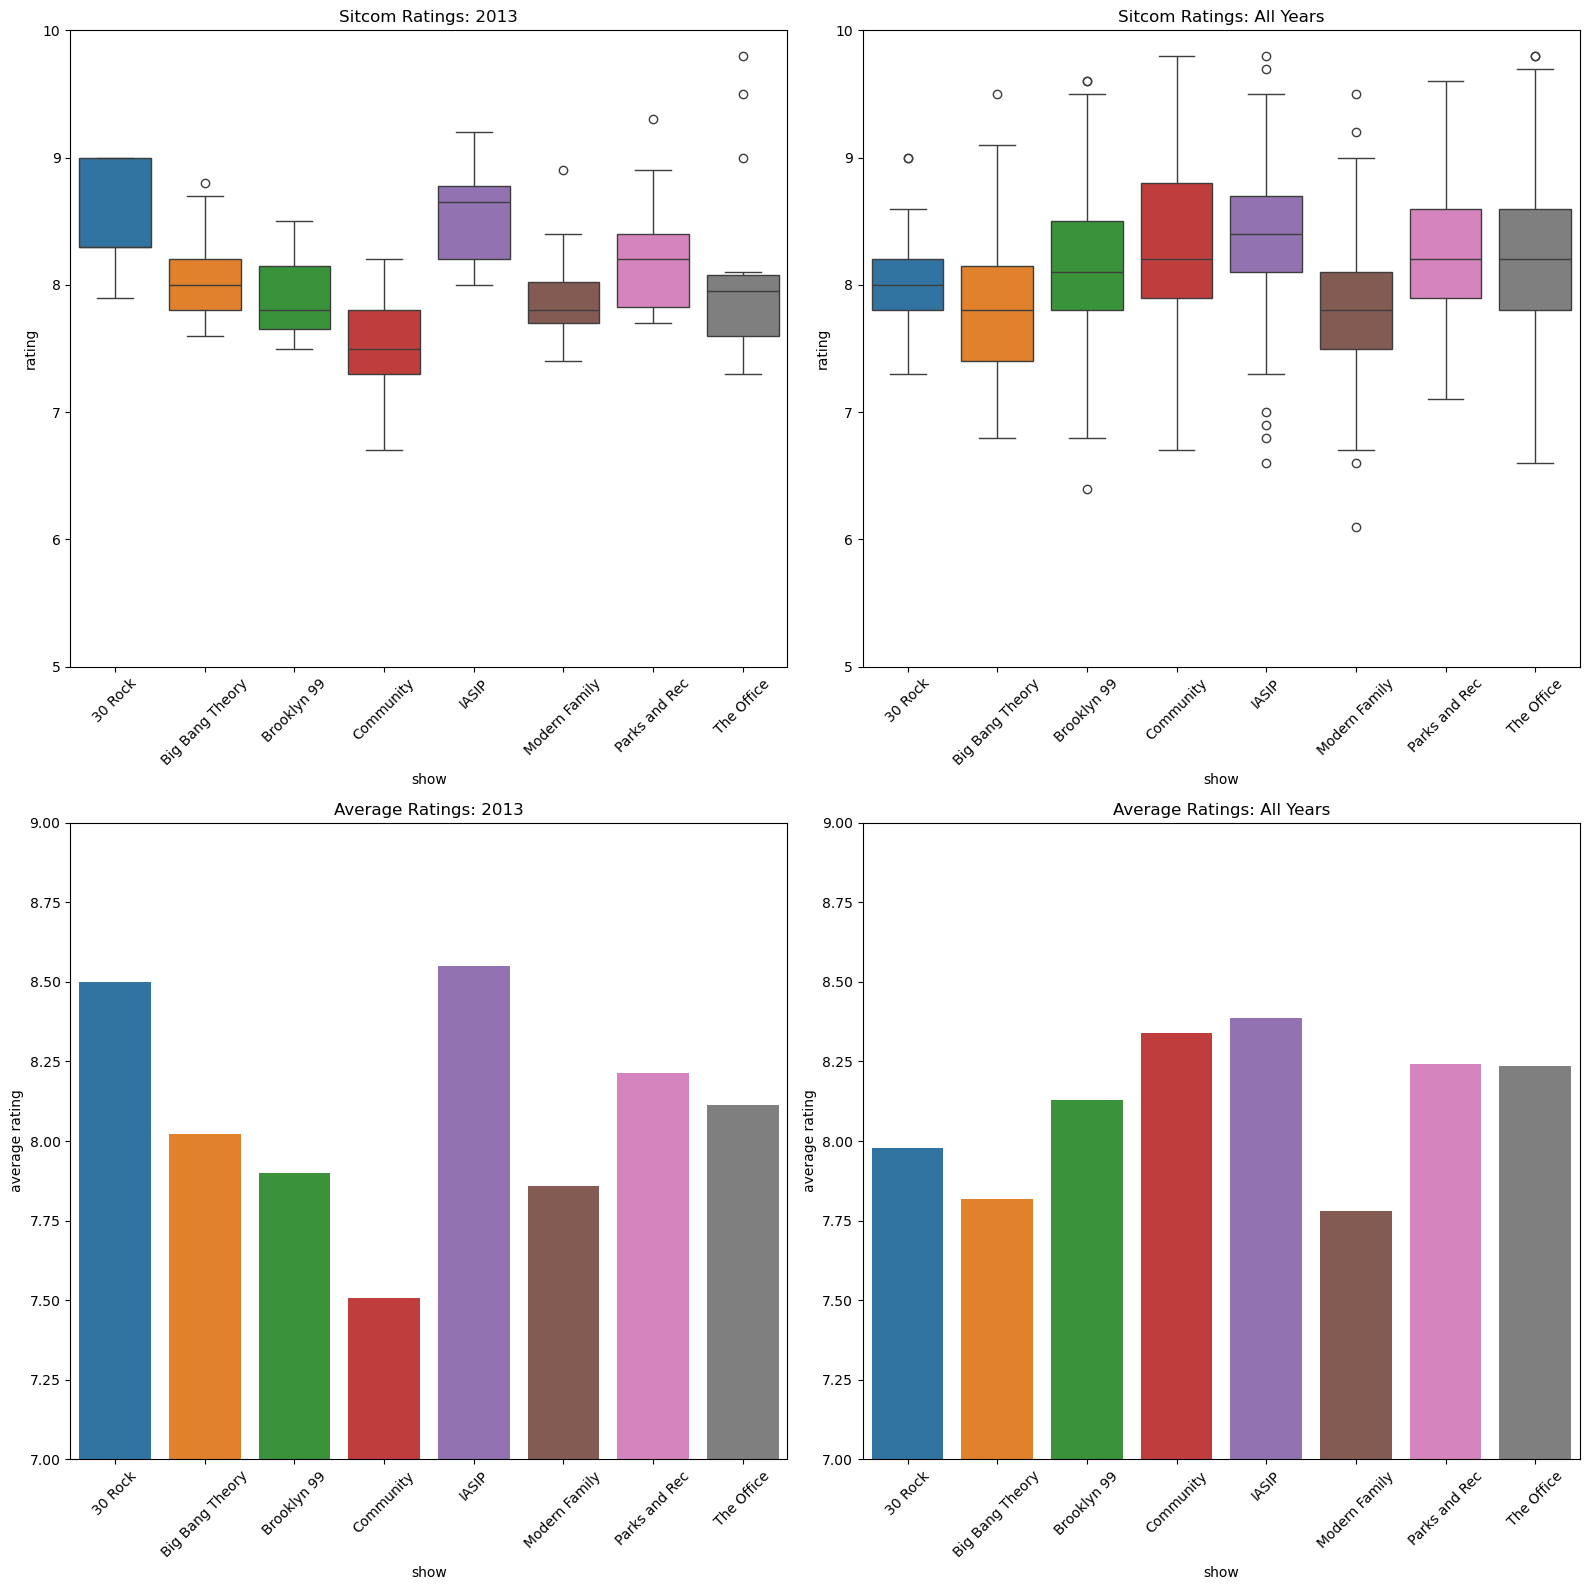

In [189]:
# Filter out the dataframe for episodes that aired in 2013
all_shows_2013=all_shows[(all_shows["year"]=="2013")]
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()
# First, plot the boxplot for each show's IMDB rating in 2013
sns.boxplot(x="show",y="rating",data=all_shows_2013.sort_values("show"),hue="show",ax=axes[0])
axes[0].set_title("Sitcom Ratings: 2013")
plt.xticks(rotation=45)
axes[0].tick_params(axis='x', rotation=45)
# Then, plot the boxplot for each show's IMDB rating overall
sns.boxplot(x="show",y="rating",data=all_shows.sort_values("show"),hue="show",ax=axes[1])
axes[1].set_title("Sitcom Ratings: All Years")
axes[1].tick_params(axis='x', rotation=45)
axes[0].set_ylim(5,10)
axes[1].set_ylim(5,10)

# Next, bar graph each show's average IMDB rating in 2013
axes[2].set_title("Average Ratings: 2013")
avg_2013 = all_shows_2013.groupby("show")["rating"].mean().reset_index().sort_values("show")
sns.barplot(x="show",y="rating",data=avg_2013,hue="show",ax=axes[2])
axes[2].tick_params(axis='x', rotation=45)

# Finally, bar graph each show's average rating overall.
axes[3].set_title("Average Ratings: All Years")
sns.barplot(hue="show",x="show",y="episode_avg",data=episode_avgs.sort_values("show"),ax=axes[3])
axes[3].tick_params(axis='x', rotation=45)
axes[2].set_ylim(7,9)
axes[3].set_ylim(7,9)
axes[2].set_ylabel("average rating")
axes[3].set_ylabel("average rating")
plt.tight_layout()
plt.show()

* From the graphs, we can make the following observations:
  - Some sitcoms performed higher than average, while others performed lower.  Notably, ***30 Rock*** exceeded its average in 2013, while ***Community*** performed far below average.
  - Seeing as the lower tail of ***Community*** lines up, this means that its worst rated episodes aired in 2013.
  - The number of high 2013 outliers for The Office could be what is keeping it from falling too far below average.
* To verify how each sitcom performed in 2013 against their overall average, we will calculate the deviation from the overall average rating for each show's 2013 average rating.  The findings will be shown in a bar graph.

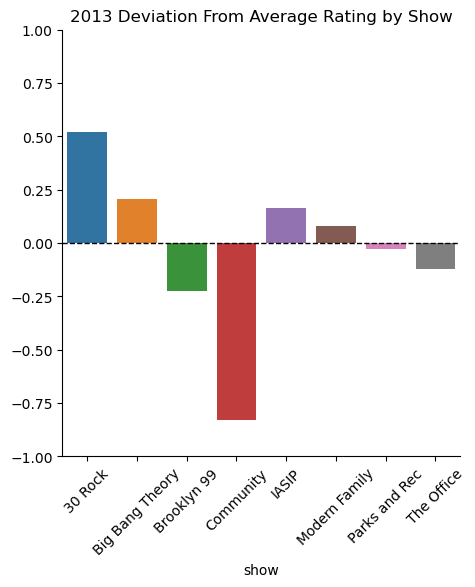

In [190]:
# Join the 2013 and overall average rating dataframes.
compare_avg=pd.merge(avg_2013,episode_avgs,on="show").rename(columns={"rating":"2013_avg","episode_avg":"overall_avg"})
# Calculate the difference between each show's 2013 and overall average rating.
compare_avg["avg_diff"]=compare_avg["2013_avg"]-compare_avg["overall_avg"]
sns.catplot(kind="bar",data=compare_avg,x="show",y="avg_diff",hue="show")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.ylim(-1,1)
plt.title("2013 Deviation From Average Rating by Show")
plt.ylabel("")
plt.show()

* This graph reaffirms what was observed in the graphs of the average ratings:
  - ***30 Rock***, ***The Big Bang Theory***, ***It's Always Sunny in Philadelphia***, and ***Modern Family*** performed above average in ratings.
  - ***Brooklyn 99***, ***Community***, ***Parks and Recreation***, and ***The Office*** performed below average in ratings.
* Something to note however is that The Office and 30 Rock aired their final episodes in 2013, while Brooklyn 99 aired its first few episodes.  Their performance at the start or end of the series does not necessarily represent the show's performance as a whole.
### How Many Episodes Did Each Show Air in 2013?
* Another factor that could impact how each show performed in 2013 is the number of episodes that aired, and whether quantity had an effect on quality.
* We will investigate this by calculating the number of episodes aired in 2013 for each show and comparing them in a bar graph.

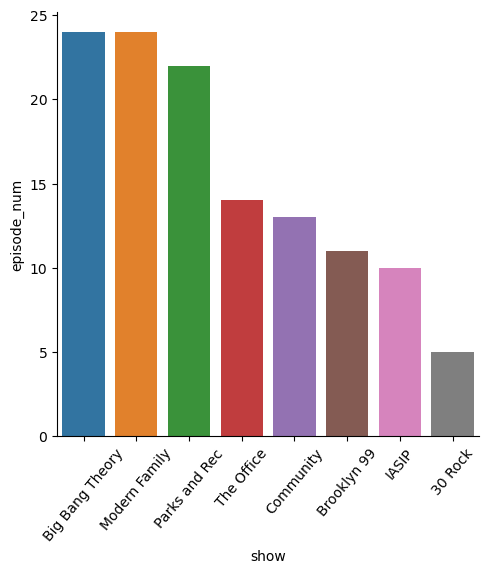

              show  episode_num
1  Big Bang Theory           24
5    Modern Family           24
6    Parks and Rec           22
7       The Office           14
3        Community           13
2      Brooklyn 99           11
4            IASIP           10
0          30 Rock            5


In [191]:
# Calculate the number of episodes released for each show in 2013
ep_counts_2013=all_shows_2013.groupby("show")["episode_num"].count().reset_index().sort_values("episode_num",ascending=False)
sns.catplot(data=ep_counts_2013,x="show",y="episode_num",hue="show",kind="bar")
plt.xticks(rotation=50)
plt.show()
print(ep_counts_2013)
plt.show()

* We see that ***The Big Bang Theory*** and ***Modern Family*** aired 24 episodes in 2013 - the most out of all shows.
* ***30 Rock*** aired 5 episodes in 2013, with these being its final episodes.
### Are The 2013 Ratings Linked To The Number Of Episodes Released That Year?
* We will calculate the correlation coefficient between episode count and average episode ratings in 2013 to see if the two factors are connected.

In [192]:
# Join the 2013 average ratings and 2013 episode counts dataframes to find the correlation coefficient
avg_vs_count=pd.merge(avg_2013,ep_counts_2013,on="show")
avg_vs_count.select_dtypes(include=np.number).corr()

,rating,episode_num
rating,1.000000,-0.368048
episode_num,-0.368048,1.000000


* The correlation is negative, but not strong enough to form a reasonable conclusion.
* Perhaps with more show data included, we could have as much data as when we calculated this correlation with all episodes.

### How Does 2013 Viewership Compare Between Shows?
* First, we'll add the amount of viewers (in millions) for each episode that premiered in 2013, and then plot them out in a line plot.

In [193]:
views_dict= {"IASIP":[0.757,0.606,0.521,0.458,0.459,0.509,0.574,0.460,0.427,0.535],
             "The Office":[4.54,4.15,4.19,4.45,3.97,4.15,4.06,3.54,3.44,3.83,3.25,3.51,4.56,5.69],
             "Community":[3.88,2.76,3.08,2.83,3.29,2.58,2.95,2.32,2.84,3.13,2.33,2.67,3.08],
             "30 Rock":[3.79,3.44,3.81,4.88,4.88],
             "Big Bang Theory":[19.25,20,17.76,18.98,17.89,17.62,17.63,15.90,17.24,15.05,16.29,16.3,15.48,18.99,20.44,18.22,17.64,17.8,16.98,16.89,18.3,18.94,15.63,17.68],
             "Parks and Rec":[3.92,3.94,3.76,3.18,3.07,2.95,3,2.93,3.15,3.35,3.34,2.59,2.99,3.27,3.27,3.14,3.23,3.27,3.03,3.03,2.81,2.81],
             "Modern Family":[12.04,11.01,10.83,9.83,10.05,10.62,10.53,9.09,10.88,10.38,9.64,9.02,10.03,10.01,11.71,11.65,11.12,10.64,10.94,10.32,10.75,10.19,9.47,10.61],
              "Brooklyn 99":[6.17,4.03,3.43,3.34,3.43,3.77,3.84,3.26,3.36,3.69,3.66]
             }
view_list=[]
for views in views_dict.values():
    view_list.extend(views)
all_shows_2013["views_in_millions"]=view_list

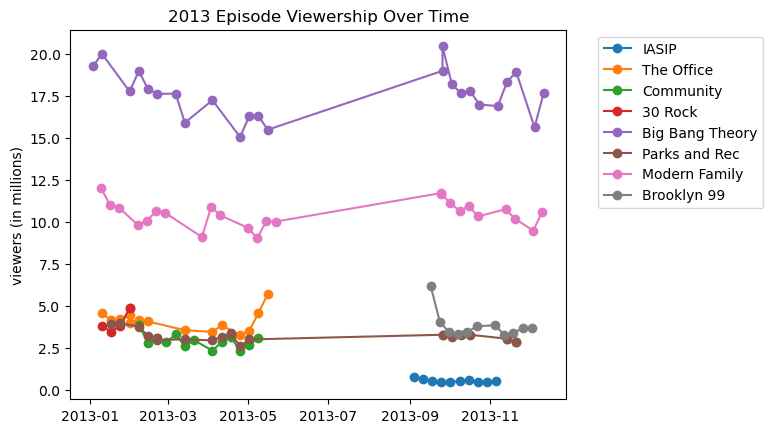

In [194]:
for show in all_shows_2013["show"].unique():
    show_2013 = all_shows_2013[all_shows_2013["show"]==show]
    plt.plot(show_2013["airdate"],show_2013["views_in_millions"],label=show,marker='o')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title("2013 Episode Viewership Over Time")
plt.ylabel("viewers (in millions)")
plt.show()

* ***The Office*** and ***30 Rock*** see a drastic rise in viewership as they approach their finales.
* ***Brooklyn 99***'s highest viewed episode in 2013 was its pilot.
* ***The Big Bang Theory*** and ***Modern Family*** have noticeably higher view counts than all other shows.
  - It should be noted that these shows air on CBS and ABC respectively.  The other channels reprsented in this data include NBC, FOX, and FX (which is the channel that broadcasts ***It's Always Sunny In Philadelphia***.  Possibly, the broadcasting networks of these shows have a hand in the amount of viewers they reach.
* Very few episodes aired between May and September, lining up with the month trends we graphed.
### On Average, How Many Viewers Per Episode Did Each Show Get in 2013?
* We will calculate the average number of viewers (in millions) for each show, and then compare the findings in a bar graph.

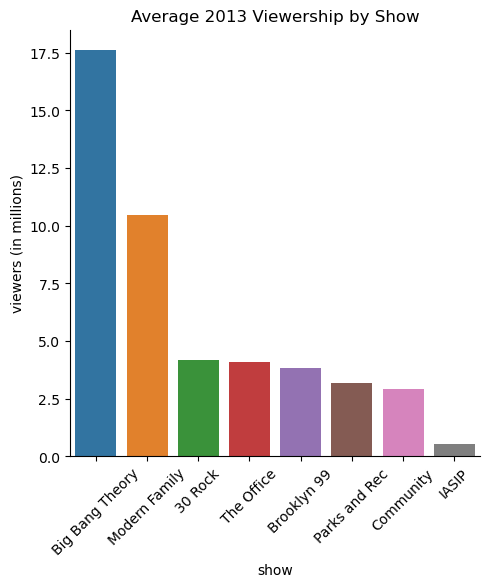

              show  views_in_millions
1  Big Bang Theory          17.620833
5    Modern Family          10.473333
0          30 Rock           4.160000
7       The Office           4.095000
2      Brooklyn 99           3.816364
6    Parks and Rec           3.183182
3        Community           2.903077
4            IASIP           0.530600


In [195]:
# Calculate the mean number of viewers per episode for each show
views_per_ep = all_shows_2013.groupby("show")["views_in_millions"].mean().reset_index().sort_values("views_in_millions",ascending=False)
sns.catplot(data=views_per_ep,x="show",y="views_in_millions",kind="bar",hue="show")
plt.xticks(rotation=45)
plt.title("Average 2013 Viewership by Show")
plt.ylabel("viewers (in millions)")
plt.show()
print(views_per_ep)

* As shown in the graph, ***The Big Bang Theory*** has the highest number of viewers per episode at about 17.6 million.  ***Modern Family*** comes in second with around 10.5 million viewers per episode.  ***It's Always Sunny In Philadelphia*** averages at about 0.53 million viewers per episode, the lowest average overall.  This lines up with the viewership overtime we plotted out.
### What Is The Most Viewed Day Of The Week?
* To investigate this, we will calculate the average number of viewers (in millions) for each day of the week and visualize them in a bar graph.

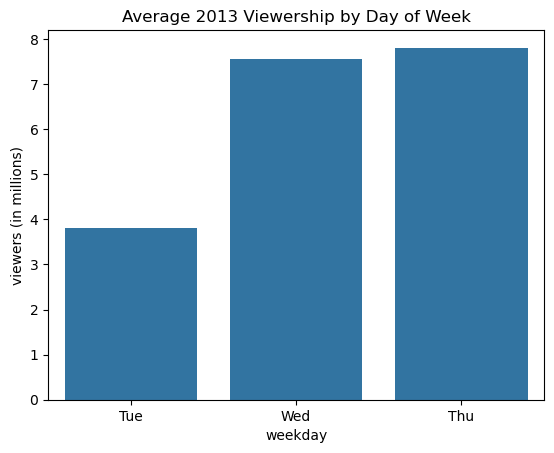

  weekday  views_in_millions
1     Tue           3.816364
2     Wed           7.549000
0     Thu           7.805128


In [196]:
# Calculate the average number of viewers (in millions) for each day of the week
day_views = all_shows_2013.groupby("weekday")["views_in_millions"].mean().reset_index().sort_values("views_in_millions")
sns.barplot(data=day_views,x="weekday",y="views_in_millions")
plt.title("Average 2013 Viewership by Day of Week")
plt.ylabel("viewers (in millions)")
plt.show()
print(day_views)

In [197]:
print(all_shows_2013.groupby(["weekday","show"])["views_in_millions"].mean().reset_index().sort_values("views_in_millions",ascending=0))

  weekday             show  views_in_millions
1     Thu  Big Bang Theory          17.620833
7     Wed    Modern Family          10.473333
0     Thu          30 Rock           4.160000
4     Thu       The Office           4.095000
5     Tue      Brooklyn 99           3.816364
3     Thu    Parks and Rec           3.183182
2     Thu        Community           2.903077
6     Wed            IASIP           0.530600


* At an average of 7.8 million viewers, Thursday seems to be the most viewed day when it comes to sitcom episodes.
* There may be some connection to our previous bar graph that showed that almost all sitcoms traditionally aired their new episodes on Thursday, contributing to this high average.
* We also see that the highest viewed show, ***The Big Bang Theory***, aired on Thursday, which contributes to Thursday being the most viewed day.

### Is there a relationship between viewership and ratings in 2013?
* To investigate this, we will first create a scatterplot to visualize the relationship between views and ratings for each show.
* Then, we will find the correlation coefficient between rating and views and see if a connection can be made.

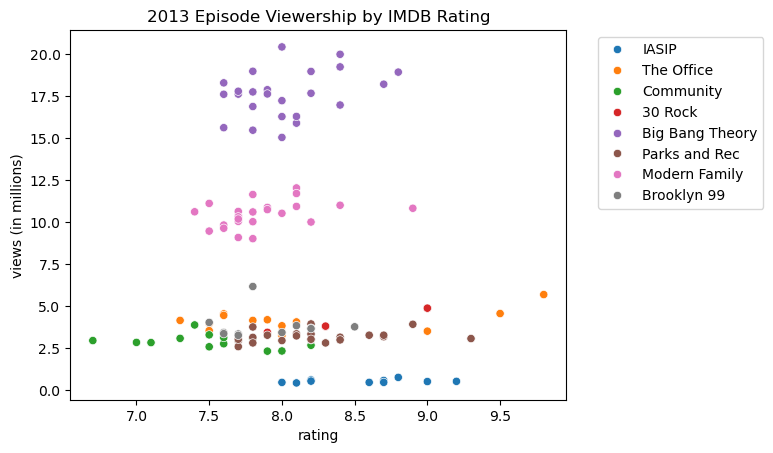

                     rating  views_in_millions
rating             1.000000          -0.091565
views_in_millions -0.091565           1.000000


In [198]:
sns.scatterplot(data=all_shows_2013, x="rating", y="views_in_millions",hue="show")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.ylabel("views (in millions)")
plt.title("2013 Episode Viewership by IMDB Rating")
plt.show()
print(all_shows_2013[["rating","views_in_millions"]].corr())

* The scatterplot shows no strong trend, but we can still draw a few observations:
  - ***The Big Bang Theory*** and ***Modern Family*** have more views than other shows, but their ratings remain consistently between 7.5 and 9.
  - Sitcoms that averaged between 2.5 and 5 million views have a wide range of ratings per episode.
  - Despite its low viewership in 2013, ***It’s Always Sunny in Philadelphia*** consistently received ratings between 8 and 10.
* With a correlation value of -0.092, we see a negative, but weak correlation, meaning we cannot reasonably link viewership to ratings without significantly more data.

## Conclusions
### How Does Episode Count Affect A Sitcom's Ratings?
* The correlation coefficient between Episode Count and Average Rating was -0.742481, hinting at a strong, negative correlation.
    - ***The Big Bang Theory*** and ***Modern Family*** have the top two highest episode counts out of all the sitcoms, but also have the lowest average ratings overall.
* The correlation coefficient between Episode Count and Rating Standard Deviation was -0.126882.  A weak negative correlation means we cannot reasonably conclude a connection between Episode Count and Ratings Consistency.
   - For example, ***Community*** released the fewest episodes, yet has the highest standard deviation of any sitcom in the data.  At the same time, ***The Office*** has the 3rd highest number of episodes but the second highest standard deviation in ratings.
### How Does Season Number Affect A Sitcom's Ratings?
* For 5 out of 8 sitcoms, the average ratings peaked at the 3rd season.  For 7 out of 8 sitcoms, the 2nd season performed better than the 1st.
* 4 out of 8 sitcoms experience a noticeable drop in ratings on the 8th season.
* The correlation coefficient between Season Number and Seasonal Average Rating is -0.28569, which is a value too weak to reasonably conclude that more seasons means a decrease in overall quality.  This makes sense, as variety of factors can occur between seasons that can change the audience reception towards each show.
  - For example, Season 8 ***The Office*** was negatively received due to major cast changes, but Season 9 has a higher average rating due to the positive audience reaction towards its series finale.
  - ***Community*** experienced a notable dip in ratings in Season 4 following the departure of showrunner Dan Harmon.  After his return in Season 5, the show's average ratings improved to previous levels.
  - ***Parks and Recreation***'s weakest season was its first, but ratings then shot up in season 2 following changes to casting and writing.
### What Is The Ideal Release Schedule For A Sitcom?
* The most popular day of the week to premiere new episodes of a sitcom is Thursday.  7 of the 8 sitcoms released new episodes on Thursday at some point of their lifespan.  Because this is the traditional day of the week to be airing sitcoms, any airing on Thursdays may improve viewership.
* The most popular seasonal timeframe to release new episodes of sitcoms is Fall-Spring.  Very few new episodes release in the months of June, July, and August, with this period usually acting as a gap between the season finale and season premiere.  This may be because during the vacation months of summer, there is less viewership overall on TV.
* With a correlation coefficient of 0.218946 between number of days between seasons and season average ratings, we cannot reasonably conclude that more time between the release of seasons can lead to that season's average ratings.  We also cannot conclude any correlation between the average number of days between seasons, the standard deviation of those seasons, and a sitcom's average episode ratings.  Sitcoms could take a hiatus between seasons for any number of reasons, and these factors could have a variety of effects on ratings.
  - The longer than average gap between ***Community***'s 3rd and 4th season can be attributed to the aforementioned departure of Dan Harmon from the show.  Meanwhile, the gap between the 5th and 6th season can be attributed to NBC canceling the show and Yahoo picking it up later.
  - ***Brooklyn 99*** and ***It's Always Sunny In Philadelphia*** experienced a season gap between seasons 7-8 and 14-15 respectively due to the COVID-19 pandemic putting a halt on production.  However, while ***Brooklyn 99***'s first season post-pandemic was its weakest in average ratings, ***It's Always Sunny In Philadelphia***'s was not dramatically different from previous seasons.
* We can, however, conclude a correlation between the a sitcom's average time gap size between seasons and the standard deviation of those time gaps.  Meaning, seasons that average a smaller gaps between seasons tend to show little variation.
  - ***It's Always Sunny In Philadelphia*** has both the largest average number of days between seasons (360+) and the largest standard deviation between season intervals (120+).
  - ***The Big Bang Theory*** and ***Modern Family*** average at 100-150 days between seasons, and are among the lowest in standard deviations, with less than 20 days for both of them.
### In 2013, Which Sitcom Was The Most Successful?
* When it comes to 2013 ratings, ***30 Rock**, ***The Big Bang Theory***, ***Modern Family***, and ***It's Always Sunny In Philadelphia*** exceeded their overall average ratings.
    - ***30 Rock*** holds both the highest average rating in 2013 and the greatest deviation from the average.  This may be because only its final 5 episodes (including the series finale) aired that year.
    - ***Community*** performed its worst in 2013, with both the lowest average and deviation from the average, coinciding with Season 4.
    - ***The Office*** performed largely below average in 2013, but its average is saved by positive audience reception a few episodes leading up to the positively received finale.
* Despite releasing the most episodes in 2013 (20+), ***The Big Bang Theory*** and ***Modern Family*** are not among the top rated sitcoms of that year.
  - With a correlation coefficient of -0.368048, we cannot conclude a correlation between episode count and ratings for the specific year of 2013.
* Of all the sitcoms in the data, ***The Big Bang Theory*** was the most viewed sitcom on average, with around 17.6 million viewers per episode.  In 2013, the show's schedule aired new episodes on Thursdays, which connects back to our findings that Thursday was the most popular day to release new episodes.  Just as we saw before, Thursday had the most viewership in 2013, largely in part to the views of ***The Big Bang Theory***.
  - The next most viewed sitcom, ***Modern Family*** averaged 10.47 million viewers.
  - All other sitcoms averaged less than 5 million viewers per episode.  ***It's Always Sunny In Philadelphia*** averaged the least, with 0.53 million per episode.  This could be attributed to demographic sizes, as more family-friendly shows like ***The Big Bang Theory*** have wider demographics in 2013 than TV-MA shows like ***It's Always Sunny In Philadelphia.***
* Still, we cannot reasonably conclude a correlation between views and ratings, as our correlation coefficient is -0.091565.
### Overall, Which Sitcom Was The Most Successful?
* With an average IMDB rating of 8.386982, ***It's Always Sunny In Philadelphia*** performed the best in ratings.
  - There are some caveats to this however.  2013 viewership showed that the sitcom may be in a niche due to its TV-MA rating, leading to fewer viewers, but a stronger positive reaction by those few viewers.  Of all sitcoms in the dataset, it also has the highest outliers and is the only one still airing new episodes as of 2025, so its ratings are subject to change.
* With a standard deviation in ratings of 0.321661, ***30 Rock*** has the most consistent ratings per episode.  While many other sitcoms see peaks and valleys over their lifetime, ***30 Rock*** is one of the few that does not drastically change in average ratings, both by episode and season.

## Final Takeaways
- Ratings and consistency don't always align with popularity or longevity.
- Sitcoms often peak early (Seasons 2–3), and decline is not always linear or guaranteed.
- Airing day and season still matter for maximizing viewership.
- Strong fan engagement doesn't always translate to high viewership (*e.g.*, *It’s Always Sunny*).

This project demonstrates how combining statistical analysis with thoughtful interpretation can yield meaningful insights into television trends.

## Dataset Sources

The data used in this project was sourced from publicly available datasets on [Kaggle](https://www.kaggle.com). Below are the specific datasets referenced:

1. **[It's Always Sunny On Kaggle](https://www.kaggle.com/datasets/kabhishm/its-always-sunny-on-kaggle)**  
   IASIP episode data

2. **[The Office Dataset](https://www.kaggle.com/datasets/nehaprabhavalkar/the-office-dataset/data)**  
   The Office episode data

3. **[Community Episodes Data](https://www.kaggle.com/datasets/bcruise/community-episodes-data)**  
   Community episode data

4. **[Big Bang Theory Episodes](https://www.kaggle.com/datasets/bcruise/big-bang-theory-episodes)**  
   The Big Bang Theory episode data

5. **[Brooklyn 99 Episodes](https://www.kaggle.com/datasets/bcruise/brooklyn-99-episode-data)**  
   Brooklyn 99 episode data

6. **[Parks and Recreation Episode Data](https://www.kaggle.com/datasets/bcruise/parks-and-recreation-episode-data)**  
   Parks and Recreation episode data

7. **[30 Rock Episode Data](https://www.kaggle.com/datasets/bcruise/30-rock-episode-data)**  
   30 Rock episode data

8. **[Modern Family TV Show: All Episodes Data](https://www.kaggle.com/datasets/rprkh15/modern-family-dataset)**  
   Modern Family episode data
> These datasets were used solely for educational and analytical purposes. All rights belong to their respective authors and data providers.
